# Convert CSV to Xarray and example plots

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
savename = "predictions/timeseries.nc"

In [ ]:
CSVlist = os.listdir('predictions/prediction_CSV')
CSVlist.remove('.DS_Store')

for n, CSVfile in enumerate(CSVlist):
    print('Adding',n+1,'/',len(CSVlist),':',CSVfile)
    times = []
    prediction = []
    predconf = []
    fogconf = []
    iceconf = []
    noconf = []

    data = pd.read_csv(os.path.join('predictions/prediction_CSV',CSVfile),header=None)
    for i in range(len(data)):
        times.append(pd.to_datetime(str(data.iloc[i,0])[:-2]))
        prediction.append(int(data.iloc[i,1]))
        predconf.append(data.iloc[i,2])
        fogconf.append(data.iloc[i,3])
        iceconf.append(data.iloc[i,4])
        noconf.append(data.iloc[i,5])
    
    new_ds = xr.Dataset(
         {
             "prediction": (["time"], prediction),
             "prediction_confidence": (["time"], predconf),
             "fog_confidence": (["time"], fogconf),
             "ice_confidence": (["time"], iceconf),
             "no_confidence": (["time"], noconf)
         },
         coords={
             "time": times,
         },
     )
    if n == 0:
        ds = new_ds
    else:
        ds = xr.concat([ds, new_ds], dim='time')

ds.to_netcdf(savename)
print('Saved as',savename)

In [3]:
ds = xr.open_dataset(savename)

## Example plots

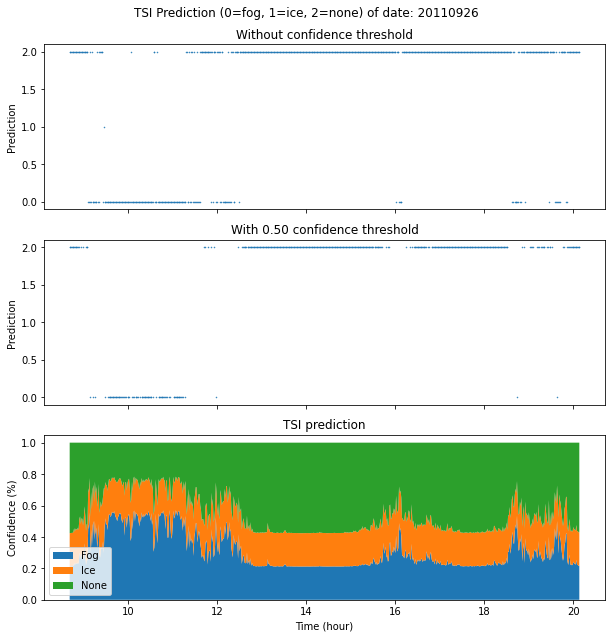

In [4]:
# plot a specific day of predictions

time = '20110926'
conf = 0.5

ds_sel = ds.sel(time=time)
ds_sel_con = ds.where(ds.prediction_confidence > conf).sel(time=time)

fig, ax = plt.subplots(3,1,figsize=(8.6,9),sharex=True)
ax[0].scatter(ds_sel.time,ds_sel.prediction,s=1,marker='.')
ax[0].set_title('Without confidence threshold')
ax[0].set_ylabel('Prediction')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax[1].scatter(ds_sel_con.time,ds_sel_con.prediction,s=1,marker='.')
ax[1].set_title('With %1.2f confidence threshold' %conf)
ax[1].set_ylabel('Prediction')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.suptitle('TSI Prediction (0=fog, 1=ice, 2=none) of date: %s' %time)

# Lookup the prediction distribution over selected time

ax[2].stackplot(ds_sel.time, [ds_sel.fog_confidence,ds_sel.ice_confidence,ds_sel.no_confidence],
             labels=['Fog','Ice','None'])
ax[2].legend(loc='lower left')
ax[2].set_title('TSI prediction')
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Confidence (%)')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.tight_layout()
plt.savefig('analysis/1_day_prediction.png')
plt.show()


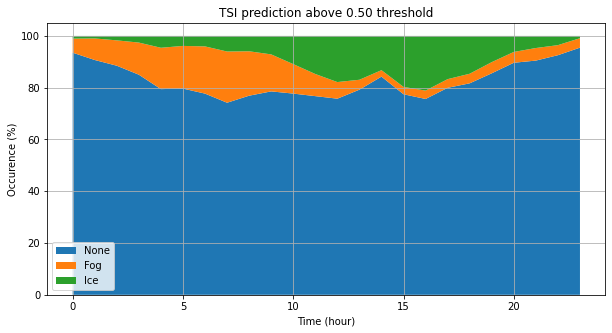

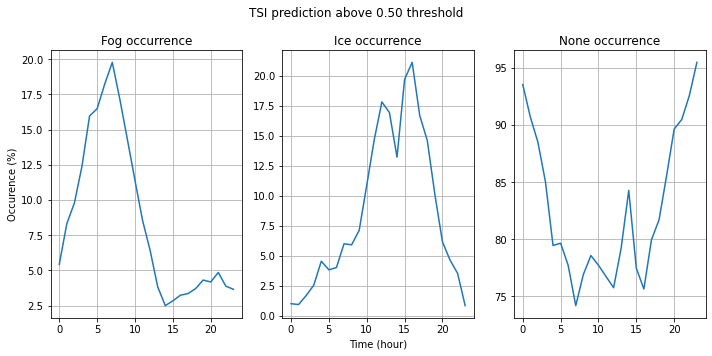

In [5]:
# fog/ice/none average distribution over all data (daily) above confidence threshold

conf = 0.5

totoccur = ds.prediction.where(ds.prediction_confidence>conf).groupby('time.hour').count()
fogoccur = ds.where(ds.prediction==0).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
iceoccur = ds.where(ds.prediction==1).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
nonoccur = ds.where(ds.prediction==2).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.hour, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction above %1.2f threshold' %conf)
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Occurence (%)')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.grid()

plt.savefig('analysis/2_daily_avg_prediction_all.png')
plt.show()

# When does fog/ice/none occur?

fig, ax = plt.subplots(1,3, sharex=True, sharey=False,figsize=(10,5))
ax[0].plot(fogoccur.hour, fogoccur)
ax[0].set_title('Fog occurrence')
ax[0].set_ylabel('Occurence (%)')
ax[0].grid()

ax[1].plot(iceoccur.hour, iceoccur)
ax[1].set_title('Ice occurrence')
ax[1].set_xlabel('Time (hour)')
ax[1].grid()

ax[2].plot(nonoccur.hour, nonoccur)
ax[2].set_title('None occurrence')
ax[2].grid()

plt.suptitle('TSI prediction above %1.2f threshold' %conf)

plt.tight_layout()
plt.savefig('analysis/3_daily_avg_prediction_seperated.png')
plt.show()


In [6]:
# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
month_ds=ds.groupby('time.month').groups

# Extract the time indices corresponding to all the Januarys 
jun_ds=month_ds[6]

# Extract the january months by selecting 
# the relevant indices
jun_ds=ds.isel(time=jun_ds)

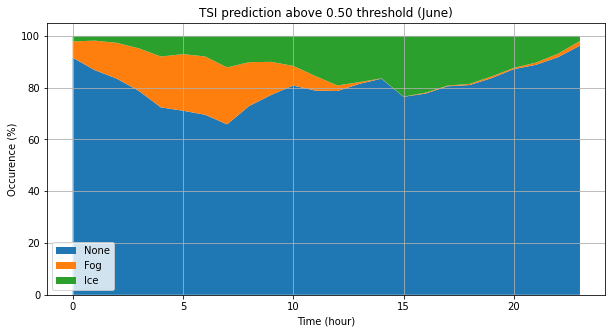

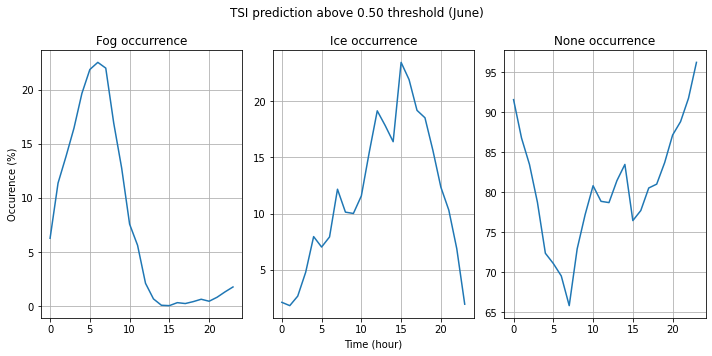

In [7]:
# fog/ice/none average distribution over all june data (daily) above confidence threshold

conf = 0.5

totoccur = jun_ds.prediction.where(jun_ds.prediction_confidence>conf).groupby('time.hour').count()
fogoccur = jun_ds.where(jun_ds.prediction==0).where(jun_ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
iceoccur = jun_ds.where(jun_ds.prediction==1).where(jun_ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
nonoccur = jun_ds.where(jun_ds.prediction==2).where(jun_ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.hour, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction above %1.2f threshold (June)' %conf)
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Occurence (%)')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.grid()

plt.savefig('analysis/6_daily_june_avg_prediction_all.png')
plt.show()

# When does fog/ice/none occur?

fig, ax = plt.subplots(1,3, sharex=True, sharey=False,figsize=(10,5))
ax[0].plot(fogoccur.hour, fogoccur)
ax[0].set_title('Fog occurrence')
ax[0].set_ylabel('Occurence (%)')
ax[0].grid()

ax[1].plot(iceoccur.hour, iceoccur)
ax[1].set_title('Ice occurrence')
ax[1].set_xlabel('Time (hour)')
ax[1].grid()

ax[2].plot(nonoccur.hour, nonoccur)
ax[2].set_title('None occurrence')
ax[2].grid()

plt.suptitle('TSI prediction above %1.2f threshold (June)' %conf)

plt.tight_layout()
plt.savefig('analysis/7_daily_june_avg_prediction_seperated.png')
plt.show()



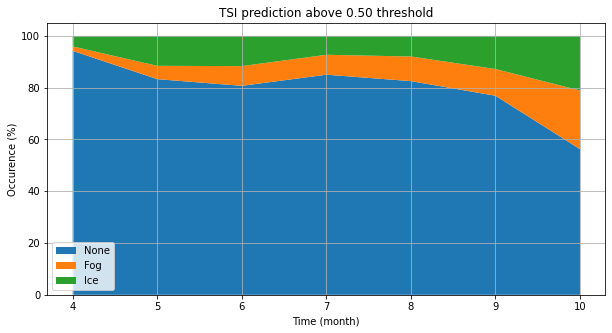

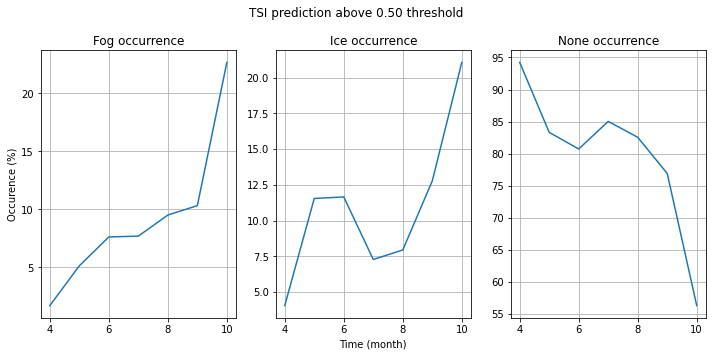

In [8]:
# which months does fog occur?

conf = 0.5

totoccur = ds.prediction.where(ds.prediction_confidence>conf).groupby('time.month').count()
fogoccur = ds.where(ds.prediction==0).where(ds.prediction_confidence>conf).prediction.groupby('time.month').count()/totoccur*100
iceoccur = ds.where(ds.prediction==1).where(ds.prediction_confidence>conf).prediction.groupby('time.month').count()/totoccur*100
nonoccur = ds.where(ds.prediction==2).where(ds.prediction_confidence>conf).prediction.groupby('time.month').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.month, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction above %1.2f threshold' %conf)
ax.set_xlabel('Time (month)')
ax.set_ylabel('Occurence (%)')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.grid()

plt.savefig('analysis/4_monthly_avg_prediction_all.png')
plt.show()

fig, ax = plt.subplots(1,3, sharex=True, sharey=False,figsize=(10,5))
ax[0].plot(fogoccur.month, fogoccur)
ax[0].set_title('Fog occurrence')
ax[0].set_ylabel('Occurence (%)')
ax[0].grid()
#ax[0].set_xlim(5,9)

ax[1].plot(iceoccur.month, iceoccur)
ax[1].set_title('Ice occurrence')
ax[1].set_xlabel('Time (month)')
ax[1].grid()

ax[2].plot(nonoccur.month, nonoccur)
ax[2].set_title('None occurrence')
ax[2].grid()

plt.suptitle('TSI prediction above %1.2f threshold' %conf)

plt.tight_layout()
plt.savefig('analysis/5_monthly_avg_prediction_seperated.png')
plt.show()


In [9]:
totoccur

<xarray.DataArray 'prediction' (month: 7)>
array([  7064, 143697, 326494, 350004, 324121, 155029,   1894])
Coordinates:
  * month    (month) int64 4 5 6 7 8 9 10

Month 10 is based on very little data, 4 too